<a href="https://colab.research.google.com/github/AlejandroVillazonG/Tareas_MAT277/blob/main/T2_MAT277_2023_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://matematica.usm.cl/wp-content/themes/dmatUSM/assets/img/logoDMAT2.png" title="Title text" width= 800 /></center>
<hr style="height:2px;border:none"/>
<h1 align='center'> MAT277 ANÁLISIS NUMÉRICO DE ECUACIONES EN DERIVADAS PARCIALES</h1>

<H3 align='center'> TAREA 2 - 2023-1  </H3>
<hr style="height:2px;border:none"/>

<H3 align='center'> Alejandro Villazón G. </H3>
<hr style="height:2px;border:none"/>


In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.sparse as sp

Primero definimos un par de funciones para elementos finitos en dos dimensiones.

In [2]:
def refineNVB(co,el,bdry,marked):
    # bisec-3 refinement of marked elements

    nE = el.shape[0]
    nN = co.shape[0]

    # obtain geometric information on edges
    [edge2nodes,element2edges,bdry2edges] = provideGeometricData(el,bdry)

    # mark edges for refinement
    nEd = np.max(element2edges)+1
    nEd = nEd.astype(np.uint64)
    edge2newNode = np.zeros(nEd,dtype='uint64')
    edge2newNode[element2edges[marked,:]] = 1
    swap = np.array([0])
    while swap.size:
        markedEdge = edge2newNode[element2edges]
        swap = np.argwhere((np.logical_not(markedEdge[:,0]))&(markedEdge[:,1]|markedEdge[:,2]))
        edge2newNode[element2edges[swap,0]] = 1

    # generate new nodes
    edge2newNode[np.nonzero(edge2newNode)] = nN + np.array(range(0,np.count_nonzero(edge2newNode)))
    idx = np.nonzero(edge2newNode)
    co = np.concatenate((co,(co[edge2nodes[idx][:,0],:] + co[edge2nodes[idx][:,1],:])/2))

    # refine boundary conditions (python indices start at 0, but doesn't matter here as 0'th node is certainly not a new one)
    newNodes = edge2newNode[bdry2edges]
    bdry = np.concatenate((bdry[newNodes == 0],np.concatenate( (bdry[newNodes != 0,0][:,np.newaxis], newNodes[newNodes != 0][:,np.newaxis]),axis=1 ),
        np.concatenate( (newNodes[newNodes != 0][:,np.newaxis],bdry[newNodes != 0,1][:,np.newaxis]),axis=1 ))).astype(np.uint64)

    # provide new nodes for refinement of elements
    newNodes = edge2newNode[element2edges]

    # determine type of refinement for each element
    markedEdges = (newNodes != 0)

    none = np.ravel(np.argwhere(np.logical_not(markedEdges[:,0])))
    bisec1 = np.ravel(np.argwhere(markedEdges[:,0] & np.logical_not(markedEdges[:,1]) & np.logical_not(markedEdges[:,2])))
    bisec12 = np.ravel(np.argwhere(markedEdges[:,0] & markedEdges[:,1] & np.logical_not(markedEdges[:,2])))
    bisec13 = np.ravel(np.argwhere(markedEdges[:,0] & np.logical_not(markedEdges[:,1]) & markedEdges[:,2]))
    bisec123 = np.ravel(np.argwhere(markedEdges[:,0] & markedEdges[:,1] & markedEdges[:,2]))

    # generate element numbering for refined mesh
    idx = np.ones(nE,dtype='uint64')
    idx[bisec1] = 2
    idx[bisec12] = 3
    idx[bisec13] = 3
    idx[bisec123] = 4
    idx = np.concatenate(([0],np.cumsum(idx))).astype(np.uint64)

    # generate new elements
    newElements = np.zeros((idx[idx.size-1],3),dtype='uint64')
    newElements[idx[none],:] = el[none,:]

    newElements[idx[bisec1]] = np.concatenate((el[bisec1,2][:,np.newaxis],
        el[bisec1,0][:,np.newaxis],newNodes[bisec1,0][:,np.newaxis]),axis=1).astype(np.uint64)
    newElements[1+idx[bisec1]] = np.concatenate((el[bisec1,1][:,np.newaxis],
        el[bisec1,2][:,np.newaxis],newNodes[bisec1,0][:,np.newaxis]),axis=1).astype(np.uint64)

    newElements[idx[bisec12]] = np.concatenate((el[bisec12,2][:,np.newaxis],
        el[bisec12,0][:,np.newaxis],newNodes[bisec12,0][:,np.newaxis]),axis=1).astype(np.uint64)
    newElements[1+idx[bisec12]] = np.concatenate((newNodes[bisec12,0][:,np.newaxis],
        el[bisec12,1][:,np.newaxis],newNodes[bisec12,1][:,np.newaxis]),axis=1).astype(np.uint64)
    newElements[2+idx[bisec12]] = np.concatenate((el[bisec12,2][:,np.newaxis],
        newNodes[bisec12,0][:,np.newaxis],newNodes[bisec12,1][:,np.newaxis]),axis=1).astype(np.uint64)

    newElements[idx[bisec13]] = np.concatenate((newNodes[bisec13,0][:,np.newaxis],
        el[bisec13,2][:,np.newaxis],newNodes[bisec13,2][:,np.newaxis]),axis=1).astype(np.uint64)
    newElements[1+idx[bisec13]] = np.concatenate((el[bisec13,0][:,np.newaxis],
        newNodes[bisec13,0][:,np.newaxis],newNodes[bisec13,2][:,np.newaxis]),axis=1).astype(np.uint64)
    newElements[2+idx[bisec13]] = np.concatenate((el[bisec13,1][:,np.newaxis],
        el[bisec13,2][:,np.newaxis],newNodes[bisec13,0][:,np.newaxis]),axis=1).astype(np.uint64)

    newElements[idx[bisec123]] = np.concatenate((newNodes[bisec123,0][:,np.newaxis],
        el[bisec123,2][:,np.newaxis],newNodes[bisec123,2][:,np.newaxis]),axis=1).astype(np.uint64)
    newElements[1+idx[bisec123]] = np.concatenate((el[bisec123,0][:,np.newaxis],
        newNodes[bisec123,0][:,np.newaxis],newNodes[bisec123,2][:,np.newaxis]),axis=1).astype(np.uint64)
    newElements[2+idx[bisec123]] = np.concatenate((newNodes[bisec123,0][:,np.newaxis],
        el[bisec123,1][:,np.newaxis],newNodes[bisec123,1][:,np.newaxis]),axis=1).astype(np.uint64)
    newElements[3+idx[bisec123]] = np.concatenate((el[bisec123,2][:,np.newaxis],
        newNodes[bisec123,0][:,np.newaxis],newNodes[bisec123,1][:,np.newaxis]),axis=1).astype(np.uint64)

    return (co,newElements,bdry)

def provideGeometricData(el,bdry):

    nE = el.shape[0]

    # node vectors of edges
    I = np.ravel(el,order='F')
    J = np.ravel(el[:,[1,2,0]],order='F')

    # symmetrize such that boundary edges appear twice
    I = np.concatenate((I,np.ravel(bdry[:,1]))).astype(np.uint64)
    J = np.concatenate((J,np.ravel(bdry[:,0]))).astype(np.uint64)

    # create numbering of edges
    idxIJ = np.ravel(np.argwhere(I<J),order='F')
    edgeNumber = np.zeros(I.size,dtype='uint64')
    edgeNumber[idxIJ] = np.array(range(0,idxIJ.size))
    idxJI = np.ravel(np.argwhere(I>J),order='F')

    M = (np.max(I)+1).astype(np.uint64) # number of nodes

    number2edges = sp.coo_matrix( ( range(1,idxIJ.size+1), (I[idxIJ],J[idxIJ])), shape=(M,M) ) # add 1 as python indices start with 0
    [foo1,foo2,numberingIJ] = sp.find(number2edges)

    number2edges2 = sp.coo_matrix( ( idxJI+1, (J[idxJI],I[idxJI])), shape=(M,M) ) # add 1 as python indices start with 0
    [foo1,foo2,idxJI2IJ] = sp.find(number2edges2)

    edgeNumber[idxJI2IJ-1] = numberingIJ-1 # subtract 1 as python indices start with 0

    # provide element2edges and edge2nodes and bdry2edges

    element2edges = np.reshape(edgeNumber[0:3*nE],(nE,3),order='F')
    edge2nodes = np.stack( (I[idxIJ],J[idxIJ]),axis=1)
    bdry2edges = edgeNumber[3*nE:edgeNumber.size]

    return (edge2nodes,element2edges,bdry2edges)

def gradgrad2d(co,el,bdry):

    N = co.shape[0]
    noEl = el.shape[0] # number of elements
    A = np.zeros([N,N])

    # derivadas de los phihat sobre el elemento de referencia
    Dphihat = np.array([[-1.0, -1.0],[1.0, 0.0],[0.0, 1.0]])

    for ll in range(noEl):

        l2g = el[ll,:]

        # determinar la matriz B. cuidado: transponer!
        B = np.array([co[l2g[1],:]-co[l2g[0],:],co[l2g[2],:]-co[l2g[0],:]]).T

        # determinar la matriz G
        G = np.linalg.inv(B)@(np.linalg.inv(B).T)*np.linalg.det(B)*0.5

        for j in range(3):
            for k in range(3):
                A[l2g[j],l2g[k]] = A[l2g[j],l2g[k]] + Dphihat[j,:]@G@Dphihat[k,:]

    # nodes on the boundary
    ngamma = np.unique(bdry)

    # inneer nodes
    ni = np.setdiff1d(range(N),ngamma)

    # devolver filas/columnas de a asociadas a nodos interiores
    return(A[ni][:,ni])

def idid2d(co,el,bdry):

    N = co.shape[0]
    noEl = el.shape[0] # number of elements
    M = np.zeros([N,N])

    Mhat = np.array([[1.0/12, 1.0/24, 1.0/24],[1.0/24, 1.0/12, 1.0/24], [1.0/24, 1.0/24, 1.0/12]])

    for ll in range(noEl):

        l2g = el[ll,:]

        # determinar la matriz B. cuidado: transponer!
        B = np.array([co[l2g[1],:]-co[l2g[0],:],co[l2g[2],:]-co[l2g[0],:]]).T

        for j in range(3):
            for k in range(3):
                M[l2g[j],l2g[k]] = M[l2g[j],l2g[k]] + np.linalg.det(B)*Mhat[j,k]

    # nodes on the boundary
    ngamma = np.unique(bdry)

    # inneer nodes
    ni = np.setdiff1d(range(N),ngamma)

    # devolver filas/columnas de a asociadas a nodos interiores
    return(M[ni][:,ni])

def loadvec(co,el,bdry,f):

    N = co.shape[0]
    noEl = el.shape[0]
    b = np.zeros((N,))

    for ll in range(noEl):

        l2g = el[ll,:]

        # determinar la matriz B. cuidado: transponer!
        B = np.array([co[l2g[1]]-co[l2g[0]],co[l2g[2]]-co[l2g[0]]]).T

        # area del elemento
        A = np.linalg.det(B)*0.5

        # determinar el centro de masa del elemento
        m = (co[l2g[0],:] + co[l2g[1],:] + co[l2g[2],:])/3.0

        for j in range(3):
            b[l2g[j]] = b[l2g[j]] + A*f(m)/3.0

    # nodes on the boundary
    ngamma = np.unique(bdry)

    # inner nodes
    ni = np.setdiff1d(range(N),ngamma)

    return b[ni]

def loadvec_time(co,el,bdry,f,t):
    # loadvec for a function f depending on time and space

    N = co.shape[0]
    noEl = el.shape[0]
    b = np.zeros((N,))

    for ll in range(noEl):

        l2g = el[ll,:]

        # determinar la matriz B. cuidado: transponer!
        B = np.array([co[l2g[1]]-co[l2g[0]],co[l2g[2]]-co[l2g[0]]]).T

        # area del elemento
        A = np.linalg.det(B)*0.5

        # determinar el centro de masa del elemento
        m = (co[l2g[0],:] + co[l2g[1],:] + co[l2g[2],:])/3.0

        for j in range(3):
            b[l2g[j]] = b[l2g[j]] + A*f(m,t)/3.0

    # nodes on the boundary
    ngamma = np.unique(bdry)

    # inner nodes
    ni = np.setdiff1d(range(N),ngamma)

    return b[ni]

El objetivo de esta tarea es resolver numéricamente el problema parabólico

$$
u'-\Delta u = f \quad \text{in } \Omega,\\
u=0 \quad \text{in } \Gamma,\\
u(t=0) = u_0.
$$

con elementos finitos en el espacio y Euler implícito en el tiempo. Ya sabemos que esta discretización se lee

$$
(\mathbf{M} + k\mathbf{A})\mathbf{u}^{n+1} = k \mathbf{b}^{n+1} + \mathbf{M} \mathbf{u}^n,
$$

donde
$$
\mathbf{M}_{j,k} = \int_\Omega \phi_k(x)\phi_j(x)\,dx\\
\mathbf{A}_{j,k} = \int_\Omega \nabla\phi_k(x)\nabla\phi_j(x)\,dx
$$

y los $\phi_j$ son una base de nuestro espacio discreto $\mathcal{S}^1_0(\mathcal{T}_h)$.
La matriz $\mathbf{A}$ se calcula como siempre con la función `gradgrad2d` de arriba, mientras
$\mathbf{M}$ se calcula con la nueva función `idid2d` de arriba. El vector $\mathbf{b}^{n}$ es

$$
\mathbf{b}^n_j = \int_\Omega f(x,t_n)\phi_j(x)\,dx,
$$

y se calcula con la nueva función `loadvec_time` que permite un parametro adicional $t$ que representa el tiempo.


Para el dato inicial vamos a usar $\mathbf{u}^0 = \Pi_h u_0$, donde
$\Pi_h: L^2(\Omega)\rightarrow\mathcal{S}^1_0(\mathcal{T}_h)$ es la proyección ortogonal en $L^2(\Omega)$.
Notamos que esta proyección se determina usando la matriz $\mathbf{M}$, es decir
$\Pi_h g$ (sus coordenadas con respecto a la base dada por los $\phi_j$) es solución de

$$
\mathbf{M} \mathbf{x} = \mathbf{b}, \qquad \text{ donde } \mathbf{b}_k = \int_\Omega g(x)\phi_k(x)\,dx.
$$

# Tarea 6.1

El objetivo es resolver

$$
u'-\varepsilon\Delta u = f \quad \text{in } \Omega,\\
u=0 \quad \text{in } \Gamma,\\
u(t=0) = 0.
$$

con un epsilon muy pequeño (es decir, el efecto de difusión es muy pequeño).
El dominio $\Omega$ es un cuadrado y la temperatura inicial es $0$.
La fuente de calor es

$$
f(x,y,t) =
\begin{cases}
1 & \text{ si } |x-0.5-0.4\cos(2\pi t)|^2 + |y-0.5-0.4\sin(2\pi t)|^2<0.01\\
0 & \text{ de no ser así}.
\end{cases}
$$

> ¿Como se comporta la fuente de calor? ¿Que comportamiento esperamos entonces para la solución $u$?

**Respuesta:** La fuente de calor $f$ es una indicatriz con valor 1 en un circulo de radio 0.01 con centro oscilante y dependiente del tiempo, viendo la gráfica de $f$ se puede observar que la fuente de calor es un circulo que rota al mover $t$ dentro del cuadrado unitario.  Esperamos el mismo comportamiento para la solución, que esta sea no nula alrededor de donde está activa la fuente de calor, generando cierta estela donde estuvo activa en un tiempo anterior la fuente.

> Dado que tenemos un factor $\varepsilon$, ¿como se lee en este caso la discretización? Coloque la matriz del lado izquierdo en la linea 43.

**Respuesta:** Dado que tenemos el factor $\varepsilon$, esta discretización se lee

$$
(\mathbf{M} + k \varepsilon \mathbf{A})\mathbf{u}^{n+1} = k \mathbf{b}^{n+1} + \mathbf{M} \mathbf{u}^n.
$$

> El código refina la malla `noref` veces y luego realiza el método de Euler implícito usando `N` pasos
hasta el tiempo final `T=1`. En cada tiempo discreto, se hace un plot de la solución. ¿La solución se comporta como se espera?

**Respuesta:** Sí, luego de ver las gráficas la solución presenta el comportamiento esperado.


0.05


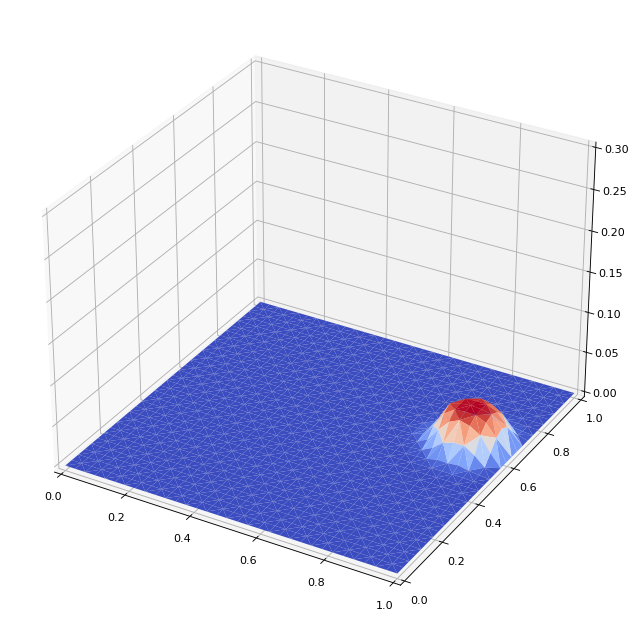

0.1


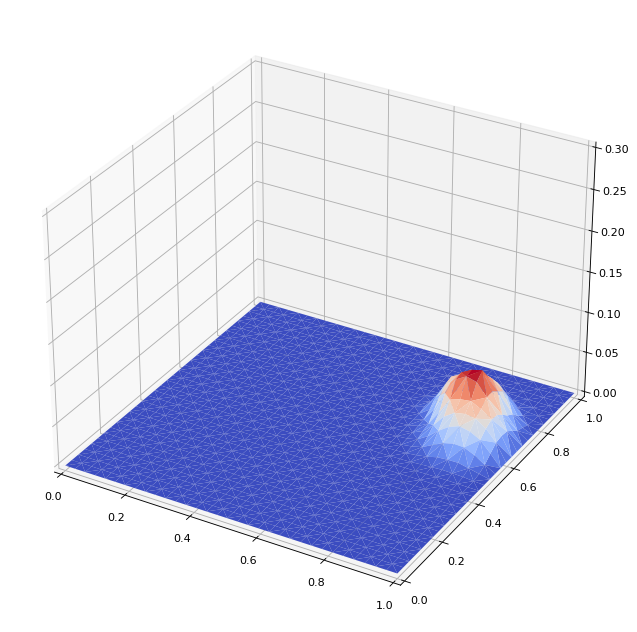

0.15000000000000002


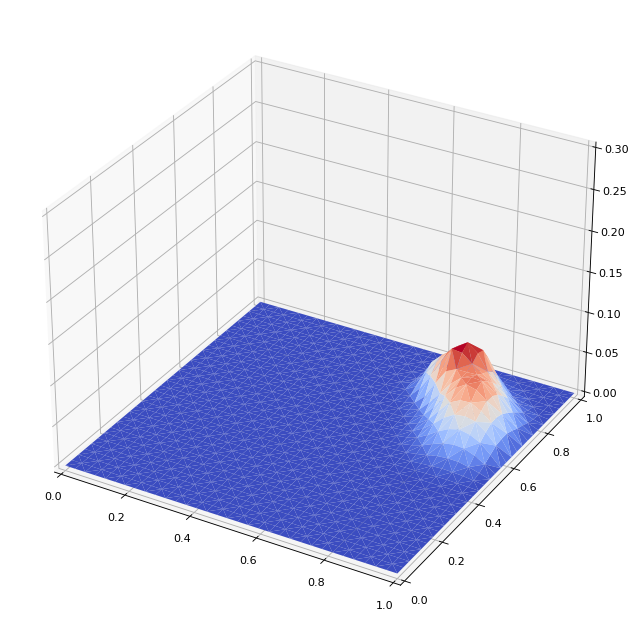

0.2


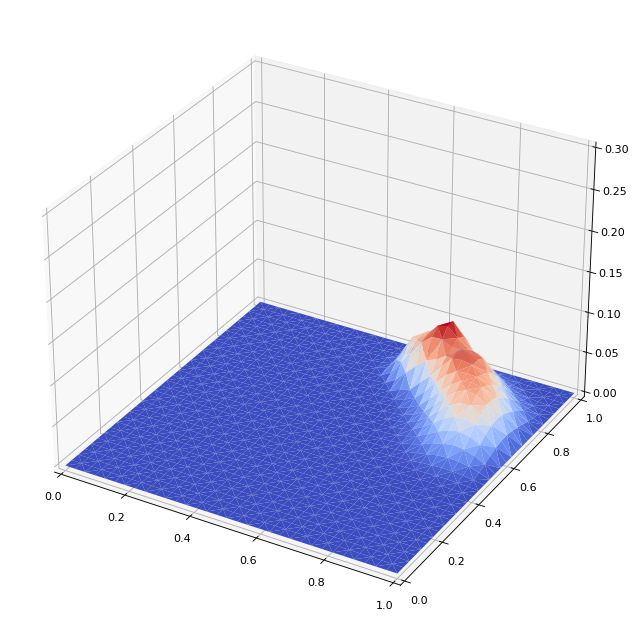

0.25


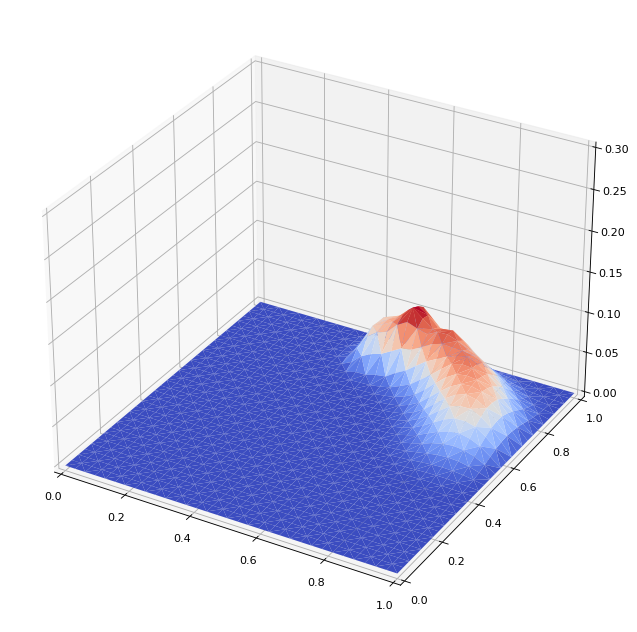

0.30000000000000004


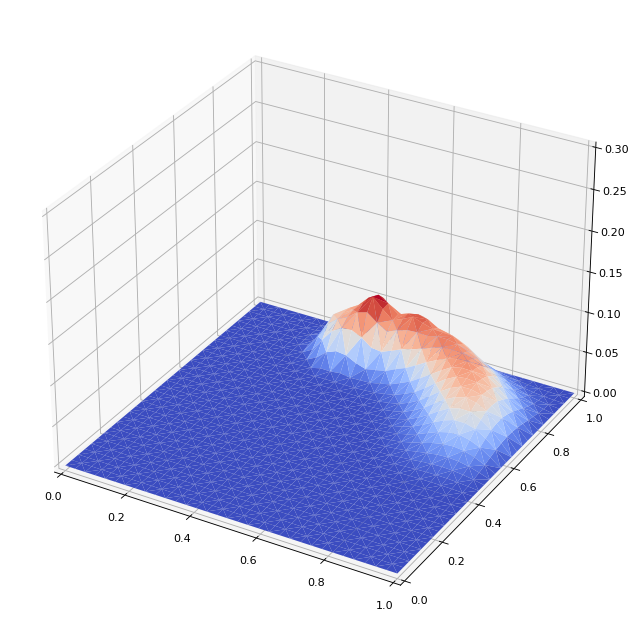

0.35000000000000003


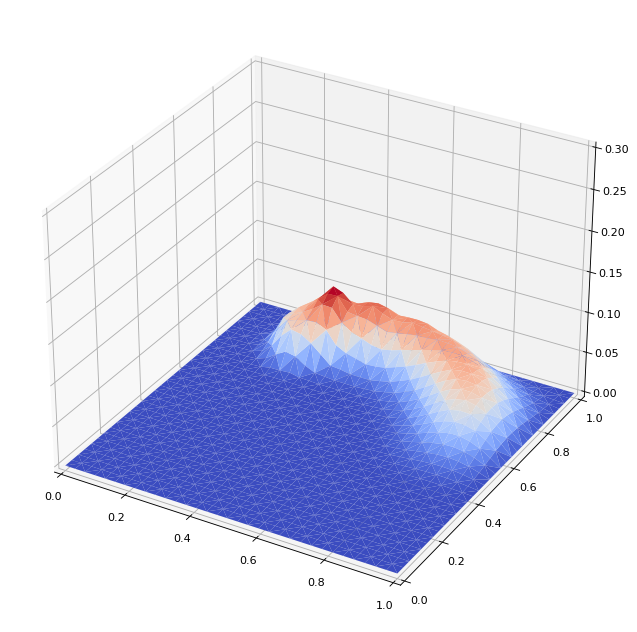

0.4


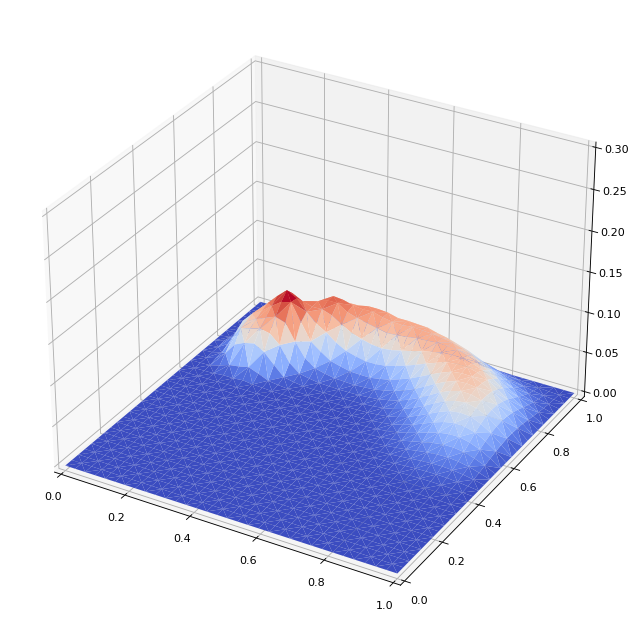

0.45


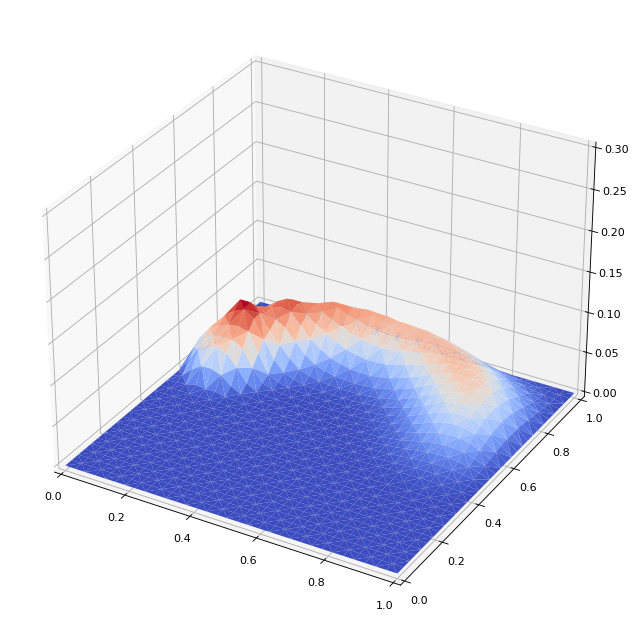

0.5


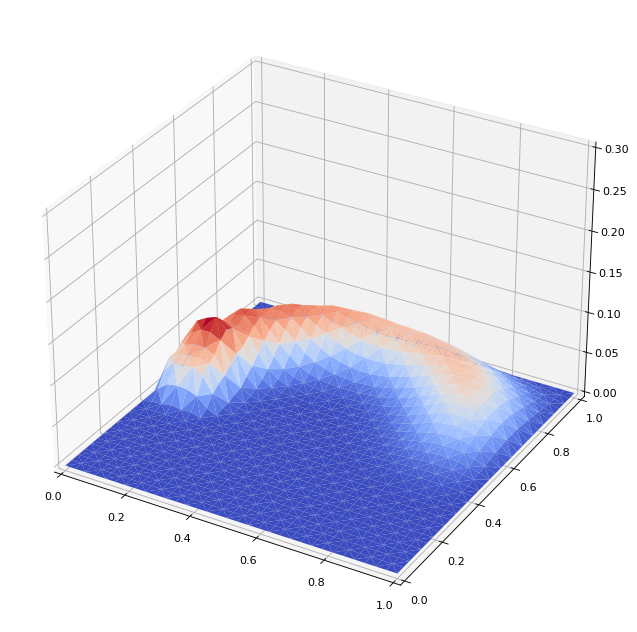

0.55


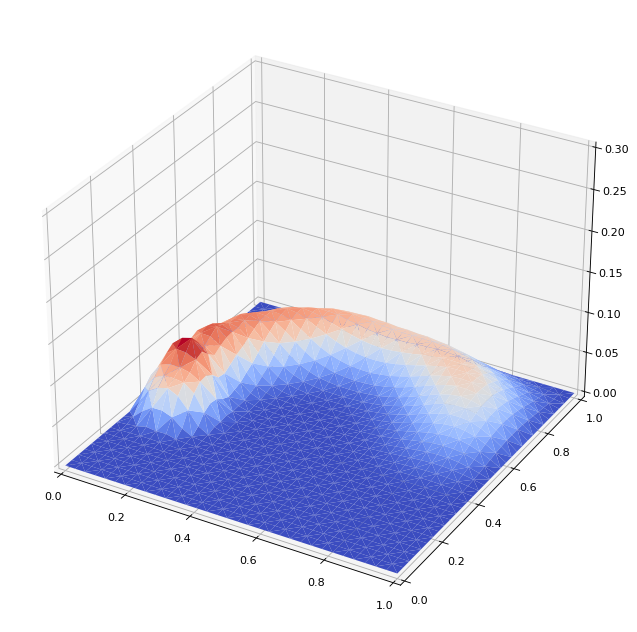

0.6000000000000001


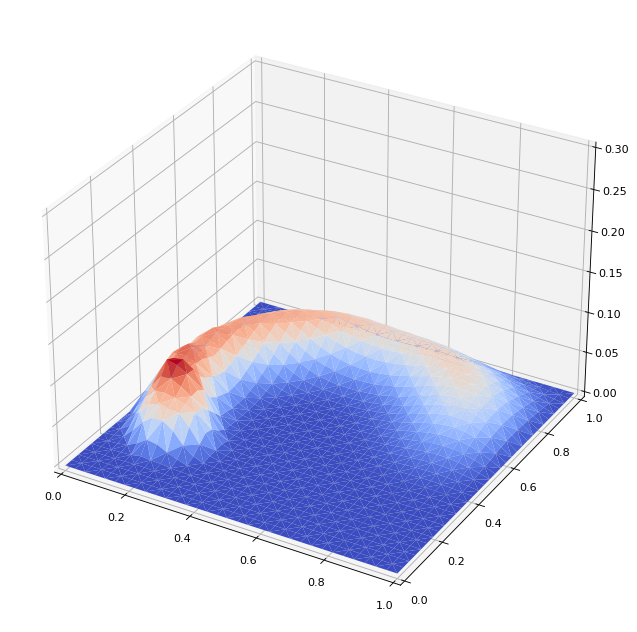

0.65


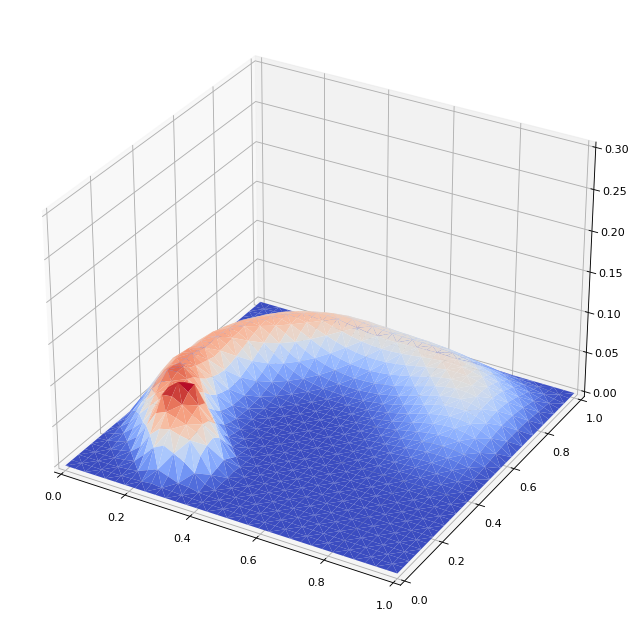

0.7000000000000001


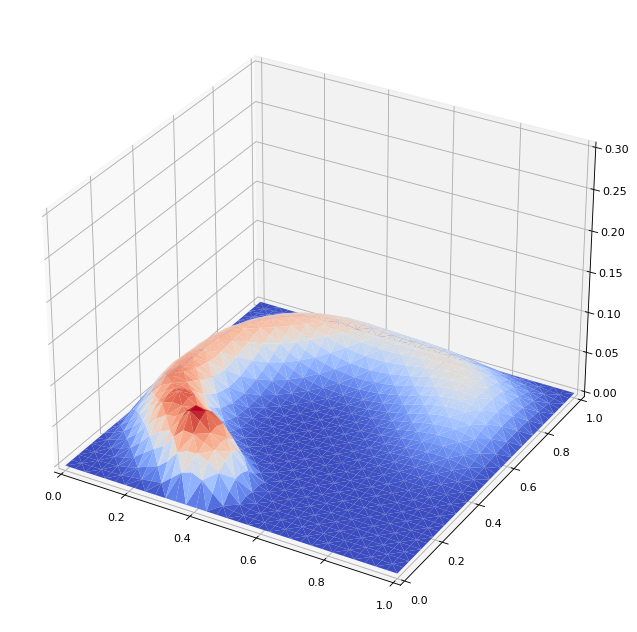

0.75


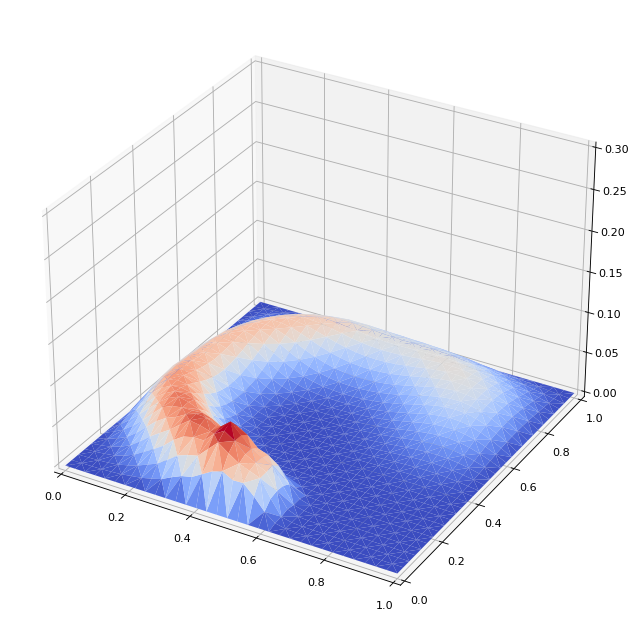

0.8


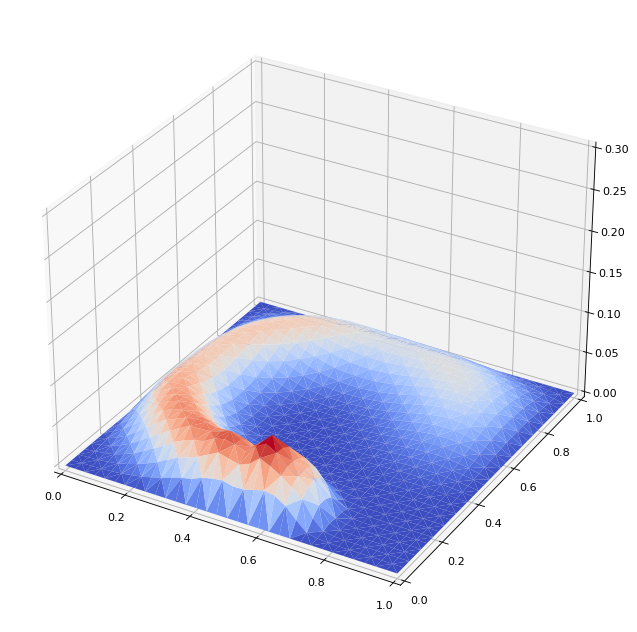

0.8500000000000001


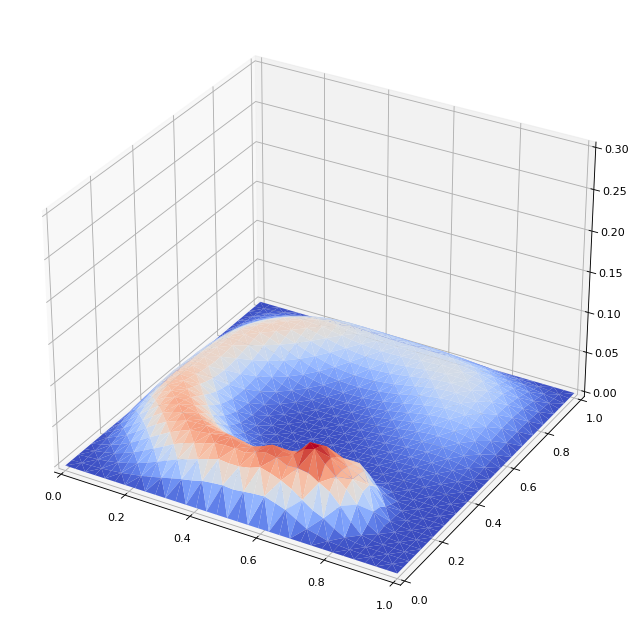

0.9


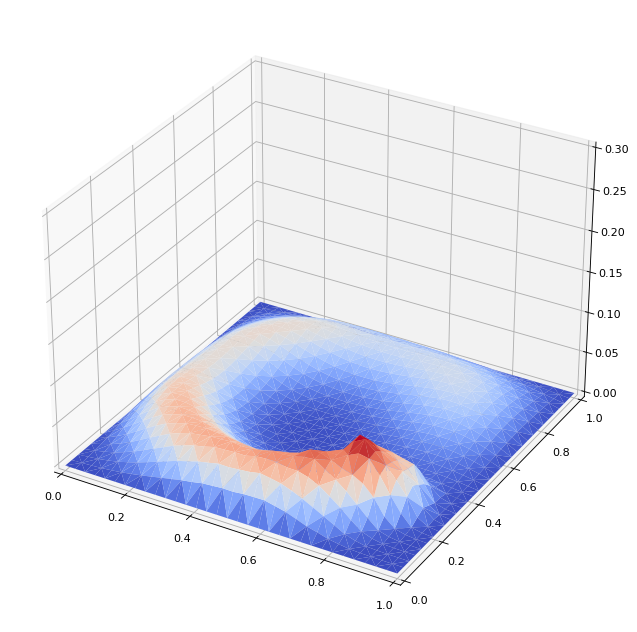

0.9500000000000001


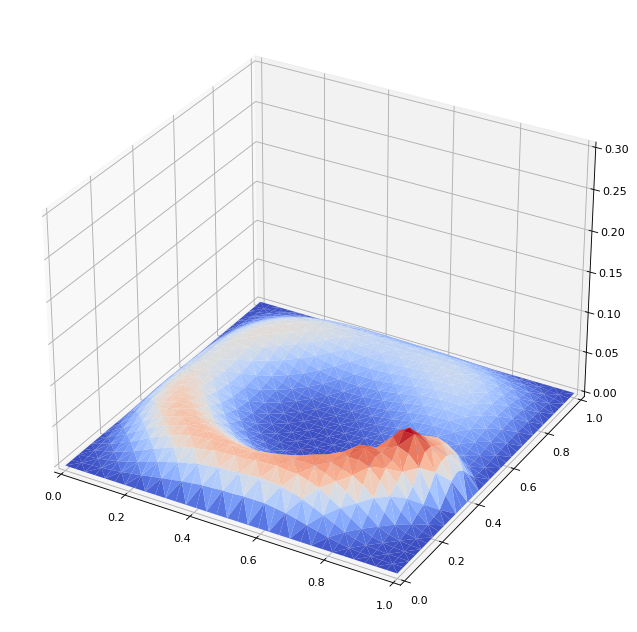

1.0


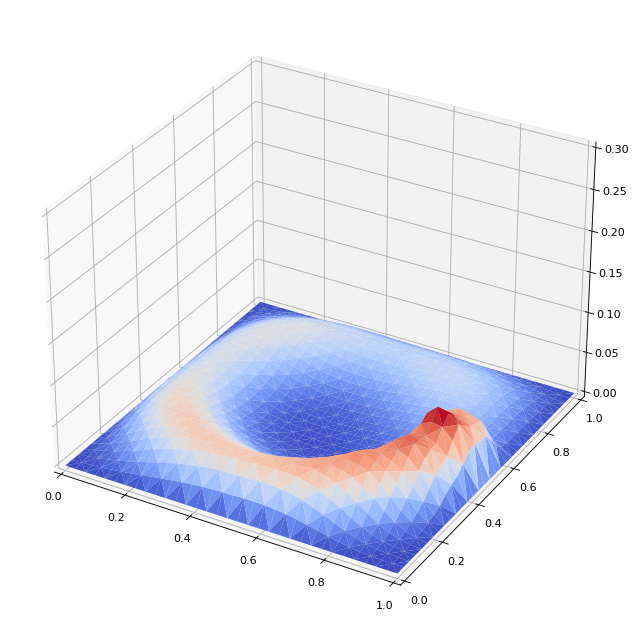

In [3]:
eps = 0.01

# temperatura inicial
def u0(x):
    return 0.0

# fuente de calor
def f(x,t):
    if (x[0]-0.5-0.4*np.cos(2*np.pi*t))**2 + (x[1]-0.5-0.4*np.sin(2*np.pi*t))**2 < 0.01:
        return 1.0
    else:
        return 0.0

# tiempo final
T = 1

# numero de pasos en el tiempo y longitud del paso temporal
N = 20
k = T/N

# definir la malla
co = np.array([[0.0,0.0],[1.0,0.0],[1.0,1.0],[0.0,1.0]])
el = np.array([[2,0,1],[0,2,3]])
bdry = np.array([[0,1],[1,2],[2,3],[3,0]])

# número de refinamientos antes de resolver
noref = 5

for j in range(0,noref):
    marked = np.array(range(0,el.shape[0]))
    [co,el,bdry] = refineNVB(co,el,bdry,marked)

# nodes on the boundary
ngamma = np.unique(bdry)

# inner nodes
ni = np.setdiff1d(range(co.shape[0]),ngamma)

A = gradgrad2d(co,el,bdry)
M = idid2d(co,el,bdry)

# matriz del sistema
B = M + eps * k * A

# calcular la proyección L2-ortogonal de u0 al espacio discreto
u0h_int = loadvec(co,el,bdry,u0)
u0h = np.linalg.solve(M,u0h_int)

un = u0h

for n in range(1,N+1):
    tn = n*k
    print(tn)
    fn = loadvec_time(co,el,bdry,f,tn)
    un = np.linalg.solve(B,k*fn+M@un)

    # agregar la condición de Dirichlet
    sol = np.zeros((co.shape[0],))
    sol[ni] = un

    # visualizar
    fig = plt.figure(num=1, clear=True, figsize=(12,10), dpi=80)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0,0.3))
    img=ax.plot_trisurf(co[:,0],co[:,1],el,sol,cmap="coolwarm")
    plt.show()

# Tarea 6.2

El objetivo es resolver

$$
u'-\Delta u = 0 \quad \text{in } \Omega,\\
u=0 \quad \text{in } \Gamma,\\
u(t=0) = u_0.
$$

sobre $\Omega = (0,1)^2$ con una solución conocida y verificar los ordenes de convergencia.

> Verifique que $u(x,y,t) = e^{-8\pi^2 t} \sin(2\pi x)\sin(2\pi y)$ es solución de la ecuación de calor y de la condición de frontera.

**Respuesta:** Note los siguientes cálculos:
$$u'(x,y,t) = -8\pi^2 e^{-8\pi^2 t} \sin(2\pi x)\sin(2\pi y) = -8\pi^2 u(x,y,t)$$

$$\frac{\partial }{\partial x}u(x,y,t) = 2\pi e^{-8\pi^2 t} \cos(2\pi x)\sin(2\pi y)$$

$$\frac{\partial }{\partial y}u(x,y,t) = 2\pi e^{-8\pi^2 t} \sin(2\pi x)\cos(2\pi y)$$

$$\frac{\partial^2 }{\partial x^2}u(x,y,t) = -4\pi^2 e^{-8\pi^2 t} \sin(2\pi x)\sin(2\pi y) = -4 \pi^2 u(x,y,t)$$

$$\frac{\partial^2 }{\partial y^2}u(x,y,t) = -4\pi^2 e^{-8\pi^2 t} \sin(2\pi x)\sin(2\pi y) = -4 \pi^2 u(x,y,t)$$

Luego,
\begin{align*}
u'(x,y,t)-\Delta u(x,y,t) &= u'(x,y,t) -\left(\frac{\partial^2 }{\partial x^2}u(x,y,t) + \frac{\partial^2 }{\partial y^2}u(x,y,t) \right)\\
&= -8\pi^2 u(x,y,t) -(-4 \pi^2 u(x,y,t) -4 \pi^2 u(x,y,t) ) \\
&= 0
\end{align*}
probando que $u$ es solución de la ecuación del calor, por otro lado, dado que $\sin(2\pi z) = 0$ para $z\in\{0,1\}$ tenemos que $u=0$ en $\Gamma=\partial \Omega$.

> En el código de arriba se resuelve en cada paso del método de Euler el sistema lineal con matriz
$\mathbf{B} = \mathbf{M} + k\mathbf{A}$. Sin embargo, será mejor calcular **al principio** una descomposición LU de $\mathbf{B}$ y en cada paso del método de Euler resolver dos sistemas triangulares.
  La descomposición LU se realiza con `scipy.linalg.lu`. Esta descomposición se lee $A = PLU$, donde
  $L,U$ son los factores triangulares y $P$ es una matriz de permutación, es decir, es ortogonal. A partir de   la linea 58, complete el código resolviendo los dos sistemas triangulares con
  `scipy.linalg.solve_triangular`. El lado derecho del sistema tiene que incorporar $P$ de alguna manera
  (y $P$ es ortogonal!)

**Respuesta:** Reemplazando en la ecuación la descomposición, $\mathbf{PLU}=\mathbf{M}$ tenemos

$$
\mathbf{PLU}\mathbf{u}^{n+1} = (\mathbf{M} + k\mathbf{A})\mathbf{u}^{n+1} = k \mathbf{b}^{n+1} + \mathbf{M} \mathbf{u}^n
$$

Luego, $$\mathbf{LU}\mathbf{u}^{n+1} = \mathbf{P^\top}( k \mathbf{b}^{n+1} + \mathbf{M} \mathbf{u}^n)$$

Haciendo el cambio de variable $\mathbf{x} = \mathbf{U}\mathbf{u}^{n+1}$, obtenemos los dos sistemas triangulares a resolver:


$$\mathbf{Lx} = \mathbf{P^\top}( k \mathbf{b}^{n+1} + \mathbf{M} \mathbf{u}^n),$$
$$\mathbf{U}\mathbf{u}^{n+1} = \mathbf{x}.$$

> En el código se mide el error al tiempo final $\| u(T) - u^n_h \|_{L^2(\Omega)}$. ¿Dado que ocupamos $h\sim k$, que orden de convergencia podemos esperar en $h$? Coloque el orden en la linea 80 y revise la gráfica de convergencia.

**Respuesta:** Dado que utilizamos $h\sim k$ por los resultados del apunte concluimos que el orden esperado es 1.

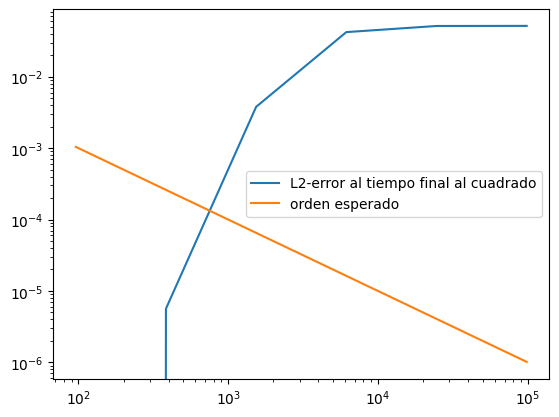

In [6]:
# solucion de u' - \Delta u = 0
def u(x,t):
    return np.exp(-2*(2*np.pi)**2*t)*np.sin(2*np.pi*x[0])*np.sin(2*np.pi*x[1])

def u0(x):
    return u(x,0)

def f(x,t):
    return 0.0

# tiempo final
T = 0.01

# solucion exacta al tiempo final
def uT(x):
    return u(x,T)

# paso temporal inicial
N = 1
k = T/N

# malla inicial
co = np.array([[0.0,0.0],[1.0,0.0],[1.0,1.0],[0.0,1.0]])
el = np.array([[2,0,1],[0,2,3]])
bdry = np.array([[0,1],[1,2],[2,3],[3,0]])

# refinamiento uniforme de la malla, h = h/2
marked = np.array(range(0,el.shape[0]))
[co,el,bdry] = refineNVB(co,el,bdry,marked)

pasos = 6
errsq = np.zeros(pasos)
nodofs = np.zeros(pasos)

for j in range(pasos):
    A = gradgrad2d(co,el,bdry)
    M = idid2d(co,el,bdry)

    # matriz del sistema
    B = M + k*A

    # descomposicion LU
    P,L,U = la.lu(B)

    # calcular la proyección L2-ortogonal de u0 al espacio discreto
    u0h_int = loadvec(co,el,bdry,u0)
    u0h = np.linalg.solve(M,u0h_int)

    # resolver
    un = u0h

    for n in range(1,N+1):
        tn = n*k
        fn = loadvec_time(co,el,bdry,f,tn)

        #un = np.linalg.solve(B,k*fn+M@un)
        # resolver las dos sistemas triangulares de A
        aux = la.solve_triangular(L , P.T @ (k*fn+M@un))
        un = la.solve_triangular(U, aux)


    # determinar proyección L2-ortogonal de u(T) al espacio discreto
    uT_int = loadvec(co,el,bdry,uT)
    Pi_uT = np.linalg.solve(M,uT_int)

    # determinar error en L2 al tiempo final
    errsq[j] = (Pi_uT - un)@M@(Pi_uT - un)

    # refinamiento uniforme de la malla, h = h/2
    marked = np.array(range(0,el.shape[0]))
    [co,el,bdry] = refineNVB(co,el,bdry,marked)

    # refinamiento uniforme del paso temporal, k = k/2
    N = 2*N
    k = T/N

    nodofs[j] = el.size

ordenesperado = 1
plt.loglog(nodofs,errsq,nodofs,10**(-1)*nodofs**(-ordenesperado))
plt.legend(['L2-error al tiempo final al cuadrado','orden esperado']);